In [1]:
print("Hello")

Hello


In [3]:
import os
from modelarts.session import Session
sess = Session()

print(sess.region_name)

if sess.region_name == 'eu-west-0':
    bucket_path="modelarts-labs/notebook/DL_face_age_prediction/ssr.tar.gz"
else:
    print("Please make sure you are in the region Paris")

if not os.path.exists("./src/align"):
    sess.download_data(bucket_path=bucket_path, path="./ssr.tar.gz")

eu-west-0


In [4]:
if os.path.exists('./ssr.tar.gz'):
    # Use tar command to unzip the resouces
    os.system("tar -xf ./ssr.tar.gz")
    # Clean the zipped package
    os.system("rm ./ssr.tar.gz")

In [5]:
!pip install mtcnn==0.0.8
!pip install numpy==1.16.2

You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import numpy as np
import cv2
import tensorflow as tf
import random
from PIL import Image

In [7]:
image_path = "./test.jpg"
img = Image.open(image_path)
img = np.array(img)

In [8]:
from mtcnn.mtcnn import MTCNN as mtcnn

detector = mtcnn()
detected = detector.detect_faces(img)

# 打印检测结果
detected

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[{'box': [66, 68, 95, 123],
  'confidence': 0.9999871253967285,
  'keypoints': {'left_eye': (101, 111),
   'mouth_left': (98, 156),
   'mouth_right': (144, 156),
   'nose': (128, 137),
   'right_eye': (142, 111)}}]

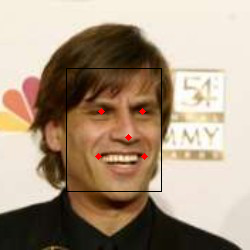

In [9]:
box = detected[0]["box"]
res_img = cv2.rectangle(img, (box[0],box[1]),(box[0]+box[2],box[1]+box[3]), 0, 1)

keypoints = detected[0]["keypoints"]
res_img = cv2.circle(res_img, keypoints['left_eye'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['right_eye'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['nose'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['mouth_left'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['mouth_right'], 1, 255, 4)

res_img = Image.fromarray(res_img)
res_img

In [10]:
from src.align.detect_face import Network
from src.align.detect_face import rerec, pad
from src.align.detect_face import nms
from src.align.detect_face import imresample
from src.align.detect_face import generateBoundingBox

In [11]:
class PNet(Network):
    def setup(self):
        (self.feed('data') 
             .conv(3, 3, 10, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='PReLU1')
             .max_pool(2, 2, 2, 2, name='pool1')
             .conv(3, 3, 16, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='PReLU2')
             .conv(3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='PReLU3')
             .conv(1, 1, 2, 1, 1, relu=False, name='conv4-1')
             .softmax(3,name='prob1'))

        (self.feed('PReLU3') 
             .conv(1, 1, 4, 1, 1, relu=False, name='conv4-2'))

In [8]:
class RNet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 28, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='prelu1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(3, 3, 48, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='prelu2')
             .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
             .conv(2, 2, 64, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='prelu3')
             .fc(128, relu=False, name='conv4')
             .prelu(name='prelu4')
             .fc(2, relu=False, name='conv5-1')
             .softmax(1,name='prob1'))

        (self.feed('prelu4') #pylint: disable=no-value-for-parameter
             .fc(4, relu=False, name='conv5-2'))

In [12]:
class ONet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='prelu1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='prelu2')
             .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
             .conv(3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='prelu3')
             .max_pool(2, 2, 2, 2, name='pool3')
             .conv(2, 2, 128, 1, 1, padding='VALID', relu=False, name='conv4')
             .prelu(name='prelu4')
             .fc(256, relu=False, name='conv5')
             .prelu(name='prelu5')
             .fc(2, relu=False, name='conv6-1')
             .softmax(1, name='prob1'))

        (self.feed('prelu5') #pylint: disable=no-value-for-parameter
             .fc(4, relu=False, name='conv6-2'))

        (self.feed('prelu5') #pylint: disable=no-value-for-parameter
             .fc(10, relu=False, name='conv6-3'))

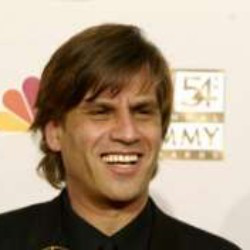

In [13]:
test_img = Image.open(image_path)
test_img

In [14]:
test_img = np.array(test_img)
img_size = np.asarray(test_img.shape)[0:2]
factor_count=0
minsize = 20
total_boxes=np.empty((0,9))
points=np.empty(0)
h=test_img.shape[0] # h=410
w=test_img.shape[1] # w=599

minl=np.amin([h, w]) # minl = [410,599] 中最小值 410
m=12.0/minsize # m=12/20
minl=minl*m # minl = 410*12/20 = 410* 0.6 
factor = 0.709 
scales=[]

while minl>=12:
    scales += [m*np.power(factor, factor_count)]
    minl = minl*factor 
    factor_count += 1

# first stage
for scale in scales:
    hs=int(np.ceil(h*scale)) #大于等于该值的最小整数
    ws=int(np.ceil(w*scale))
    im_data = cv2.resize(test_img, (ws, hs), interpolation=cv2.INTER_AREA)
    im_data = (im_data-127.5)*0.0078125
    img_x = np.expand_dims(im_data, 0)
    img_y = np.transpose(img_x, (0,2,1,3))

In [15]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        with tf.variable_scope('pnet'):
            data = tf.placeholder(tf.float32, shape=(None, None, None, 3), name="input")
            pnet = PNet({'data':data})
            pnet.load("./src/align/PNet.npy", sess)
            out = sess.run(('pnet/conv4-2/BiasAdd:0', 'pnet/prob1:0'), feed_dict={'pnet/input:0':img_y})
            
#  boundingbox regression 结果 
out0 = np.transpose(out[0], (0,2,1,3))
#  face classification 结果
out1 = np.transpose(out[1], (0,2,1,3))

threshold = 0.5
boxes, reg = generateBoundingBox(out1[0,:,:,1].copy(), out0[0,:,:,:].copy(), scale, threshold)
print("PNet产生结果为："+str(boxes.shape))
            
total_boxes = boxes.copy()

PNet产生结果为：(4, 9)


In [13]:
def draw_bboxes(img, total_boxes):
   
    for i in range(total_boxes.shape[0]):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)

        x1 = int(total_boxes[:,0][i])
        y1 =  int(total_boxes[:,1][i])
        x2=  int(total_boxes[:,2][i])
        y2 =  int(total_boxes[:,3][i])

        img = cv2.rectangle(img,(x1,y1),(x2,y2), (r,g,b), 2)
    
    return img

In [ ]:
img = Image.open(image_path)
img = np.array(img)
Image.fromarray(draw_bboxes(img,total_boxes))
total_boxes=np.empty((0,9))
pick = nms(boxes.copy(), 0.7, 'Union')

if boxes.size>0 and pick.size>0:
    boxes = boxes[pick,:]
    total_boxes = np.append(total_boxes, boxes, axis=0)
print("筛选之后结果为："+str(total_boxes.shape))
# 绘制筛选后的边界框
img = Image.open(image_path)
img = np.array(img)

# 进行nms计算 参数为0.7
pick = nms(total_boxes.copy(), 0.6, 'Union')
total_boxes = total_boxes[pick,:]
print(total_boxes.shape)

# 边界框回归
regw = total_boxes[:,2]-total_boxes[:,0]
regh = total_boxes[:,3]-total_boxes[:,1]
qq1 = total_boxes[:,0]+total_boxes[:,5]*regw
qq2 = total_boxes[:,1]+total_boxes[:,6]*regh
qq3 = total_boxes[:,2]+total_boxes[:,7]*regw
qq4 = total_boxes[:,3]+total_boxes[:,8]*regh
total_boxes = np.transpose(np.vstack([qq1, qq2, qq3, qq4, total_boxes[:,4]]))
print(total_boxes.shape)
img = Image.open(image_path)
img = np.array(img)

# 将边界框形状转为正方形
total_boxes = rerec(total_boxes.copy())
print(total_boxes)

# 将边界框坐标整理成整数
total_boxes[:,0:4] = np.fix(total_boxes[:,0:4]).astype(np.int32)
print(total_boxes)
dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)

img = Image.open(image_path)
img = np.array(img)
Image.fromarray(draw_bboxes(img,total_boxes))

In [ ]:
numbox = total_boxes.shape[0] 
tempimg = np.zeros((24,24,3,numbox))
for k in range(0,numbox):
    tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
    tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
    if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
        tempimg[:,:,:,k] = imresample(tmp, (24, 24))
    else:
        print(0)
tempimg = (tempimg-127.5)*0.0078125
tempimg1 = np.transpose(tempimg, (3,1,0,2))
with tf.Graph().as_default():
    with tf.Session() as sess:
        with tf.variable_scope('rnet'):
            data = tf.placeholder(tf.float32, shape=(None, 24, 24, 3), name="input")
            rnet = RNet({'data':data})
            rnet.load("./src/align/RNet.npy", sess)
            out = sess.run(('rnet/conv5-2/conv5-2:0', 'rnet/prob1:0'), feed_dict={'rnet/input:0':tempimg1})
            
# 检测到的人脸坐标
out0 = np.transpose(out[0])
out1 = np.transpose(out[1])

score = out1[1,:]
threshold = 0.7
ipass = np.where(score>0.2)
total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
mv = out0[:,ipass[0]]
if total_boxes.shape[0]>0:
    pick = nms(total_boxes, threshold, 'Union')
    total_boxes = total_boxes[pick,:]
    print(total_boxes)

img = Image.open(image_path)
img = np.array(img)
    
from src.align.detect_face import bbreg
# 边界框回归
total_boxes = bbreg(total_boxes.copy(), np.transpose(mv[:,pick]))
print(total_boxes)
# 边界框整理成正方形
total_boxes = rerec(total_boxes.copy())
print(total_boxes)

img = Image.open(image_path)
img = np.array(img)
Image.fromarray(draw_bboxes(img,total_boxes))

In [ ]:
numbox = total_boxes.shape[0]
total_boxes = np.fix(total_boxes).astype(np.int32)
dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)

tempimg = np.zeros((48,48,3,numbox))
for k in range(0,numbox):
    tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
    tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
    if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
        tempimg[:,:,:,k] = imresample(tmp, (48, 48))
    else:
        print(0)
tempimg = (tempimg-127.5)*0.0078125
tempimg1 = np.transpose(tempimg, (3,1,0,2))
with tf.Graph().as_default():
    with tf.Session() as sess:
        with tf.variable_scope('onet'):
            data = tf.placeholder(tf.float32, shape=(None, 48, 48, 3), name="input")
            onet = ONet({'data':data})
            rnet.load("./src/align/ONet.npy", sess)
            out = sess.run(('onet/conv6-2/conv6-2:0', 'onet/conv6-3/conv6-3:0', 'onet/prob1:0'), feed_dict={'onet/input:0':tempimg1})
            
# 人脸区域边界框预测结果
out0 = np.transpose(out[0])
# 人脸关键点预测结果
out1 = np.transpose(out[1])
# 人脸区域置信度
out2 = np.transpose(out[2])

score = out2[1,:]
points = out1
# threshold = 0.7
ipass = np.where(score>0.7)
points = points[:,ipass[0]]
total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
mv = out0[:,ipass[0]]

w = total_boxes[:,2]-total_boxes[:,0]+1
h = total_boxes[:,3]-total_boxes[:,1]+1
points[0:5,:] = np.tile(w,(5, 1))*points[0:5,:] + np.tile(total_boxes[:,0],(5, 1))-1
points[5:10,:] = np.tile(h,(5, 1))*points[5:10,:] + np.tile(total_boxes[:,1],(5, 1))-1
if total_boxes.shape[0]>0:
    total_boxes = bbreg(total_boxes.copy(), np.transpose(mv))
    pick = nms(total_boxes.copy(), 0.7, 'Min')
    total_boxes = total_boxes[pick,:]
    points = points[:,pick]
img = Image.open(image_path)
img = np.array(img)

r = random.randint(0, 255)
g = random.randint(0, 255)
b = random.randint(0, 255)

point_color = (r, g, b) 

for i in range(5):
    cv2.circle(img,(int(points[i]),int(points[i+5])),1, point_color, 4)
    
Image.fromarray(draw_bboxes(img,total_boxes))

In [ ]:
from SSRNET_model import SSR_net

weight_file = "./ssrnet_3_3_3_64_1.0_1.0.h5"

img_size = 64
stage_num = [3,3,3]
lambda_local = 1
lambda_d = 1
model = SSR_net(img_size,stage_num, lambda_local, lambda_d)()
model.load_weights(weight_file)

In [ ]:
model.summary()